In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import logging

# PyTorch Lightning
import lightning as pl

# Calvera bandit library
from calvera.bandits import DiagonalPrecApproxLinearTSBandit
from calvera.utils import TopKSelector
from calvera.benchmark import BanditBenchmarkEnvironment
from calvera.benchmark.datasets import SyntheticCombinatorialDataset


Context shape: torch.Size([20, 80])
Reward shape: torch.Size([20])

Rewards: [0.0009425383759662509, 0.01591693051159382, 0.0020510931499302387, 0.010034953244030476, 3.051970270462334e-05, 0.005022116005420685, 0.007191677577793598, 0.0016485119704157114, 0.006944944150745869, 0.01584775559604168, 0.029920300468802452, 2.3011356461211108e-05, 0.0015777185326442122, 0.029857859015464783, 0.0005690084653906524, 0.00090129638556391, 9.238207894668449e-06, 0.003150854492560029, 2.8514810765045695e-05, 0.020021598786115646]

Top 4 arms: [10, 13, 19, 1]
Top 4 rewards: [0.029920300468802452, 0.029857859015464783, 0.020021598786115646, 0.01591693051159382]


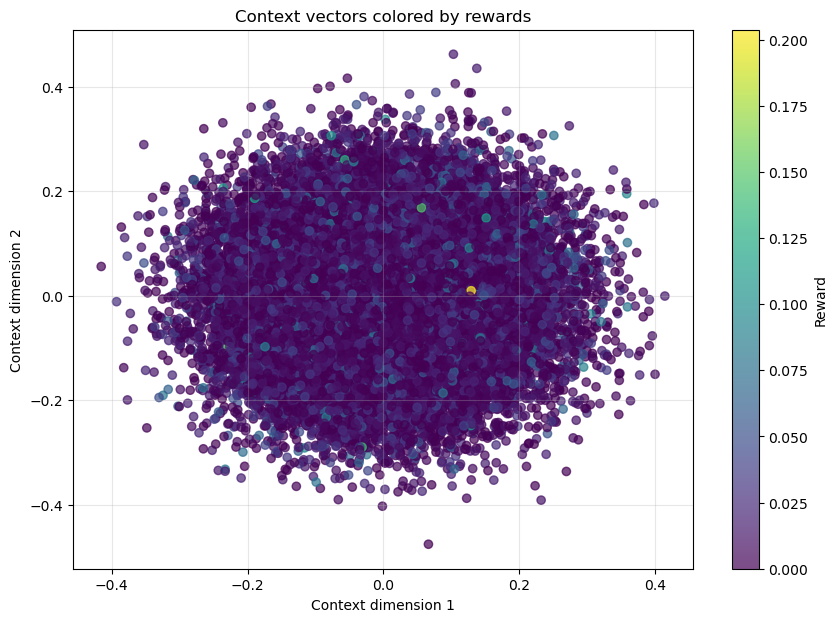

In [2]:
# Create a synthetic dataset for combinatorial bandits
dataset = SyntheticCombinatorialDataset(
    n_samples=2000,           # Number of samples
    num_actions=20,           # Total number of possible actions
    context_size=80,          # Dimension of context features
    function_type="quadratic", # Reward function type
    seed=42
)

# Examine a single example
contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

# Check the top-K arms for this example
K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

# Visualize the first two dimensions of the context features
plt.figure(figsize=(10, 7))
plt.scatter(
    dataset.contexts.view(-1, dataset.context_size)[:, 0],
    dataset.contexts.view(-1, dataset.context_size)[:, 1],
    c=dataset.rewards.view(-1, dataset.context_size)[:],
    cmap="viridis",
    alpha=0.7
)
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")
plt.grid(alpha=0.3)
plt.show()

In [3]:
# Configuration
K = 4                    # Number of items to select
BATCH_SIZE = 100         # Batch size for training
ACCELERATOR = "cpu"      # Computation device

# Create data loader with the dataset
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the bandit environment
env = BanditBenchmarkEnvironment(train_loader)

# Initialize the DiagonalPrecApproxLinearTSBandit module with TopKSelector
bandit_module = DiagonalPrecApproxLinearTSBandit(
    n_features=dataset.context_size,
    selector=TopKSelector(k=K),     # Select top K arms
    lazy_uncertainty_update=True,   # Update uncertainty lazily for efficiency
).to(ACCELERATOR)

# Configure logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [4]:
# Initialize arrays to store metrics
rewards = np.array([])
regrets = np.array([])

# Training loop with progress bar
progress = tqdm(iter(env), total=len(env), desc="Training Linear TS bandit")

for contextualized_actions in progress:
    # 1. Select actions based on current model
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    # 2. Set up trainer for this step
    trainer = pl.Trainer(
        max_epochs=1,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
        accelerator=ACCELERATOR,
    )
    
    # 3. Get feedback and compute regret
    chosen_contextualized_actions, realized_scores = env.get_feedback(chosen_actions)
    realized_rewards = realized_scores.sum(dim=1)  # Sum rewards across selected items
    batch_regret = env.compute_regret(chosen_actions)

    # 4. Record metrics
    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    # 5. Update progress bar with current metrics
    progress.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
        acc_regret=np.sum(regrets),
    )

    # 6. Update the bandit with feedback
    bandit_module.record_feedback(chosen_contextualized_actions, realized_scores)
    trainer.fit(bandit_module)
    bandit_module = bandit_module.to(ACCELERATOR)

# Store metrics in a DataFrame
metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})

# Display the first few rows of metrics
metrics.head()

Training Linear TS bandit:   0%|          | 0/20 [00:00<?, ?it/s, acc_regret=9.19, avg_regret=0.0919, regret=0.0919, reward=0.0447]c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Training Linear TS bandit: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, acc_regret=138, avg_regret=0.0692, regret=0.0557, reward=0.0905] 


,reward,regret
0,0.016614,0.059906
1,0.111069,0.091257
2,0.047188,0.077208
3,0.021675,0.067737
4,0.048148,0.041577


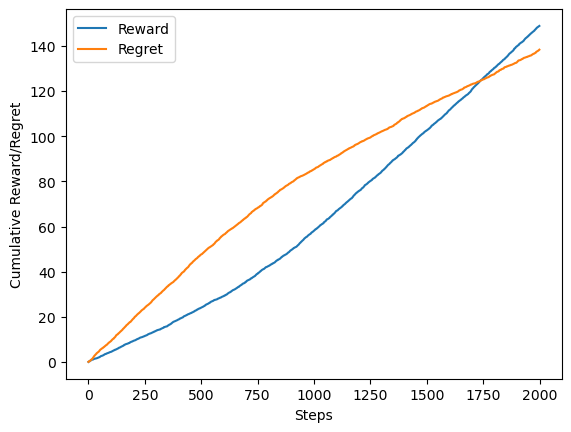

In [5]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative regret and reward
plt.plot(cumulative_reward, label="Reward")
plt.plot(cumulative_regret, label="Regret")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward/Regret")
plt.legend()
plt.show()

In [6]:
# Calculate metrics for each time horizon
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.0605
Average reward (first 100 rounds): 0.0447
Average reward (all rounds): 0.0744

Average regret (first 10 rounds): 0.0667
Average regret (first 100 rounds): 0.0919
Average regret (all rounds): 0.0692
